Spark installation video: https://www.youtube.com/watch?v=ZCliLOEKQWc

****Initializing Spark****

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [4]:
!pip install pyspark

In [5]:
from pyspark.sql import SparkSession

'''spark = SparkSession.builder.master("local[*]").getOrCreate()'''
spark = SparkSession.builder \
    .appName("Sleep Health Analysis") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()
spark

In [6]:
from pyspark.sql.functions import col

In [7]:
!pip install kaggle

!kaggle datasets download -d uom190346a/sleep-health-and-lifestyle-dataset
!unzip sleep-health-and-lifestyle-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset
License(s): CC0-1.0
  0% 0.00/2.54k [00:00<?, ?B/s]
100% 2.54k/2.54k [00:00<00:00, 5.97MB/s]
Archive:  sleep-health-and-lifestyle-dataset.zip
  inflating: Sleep_health_and_lifestyle_dataset.csv  


****Loading Data****
<br> link to dataset: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset

In [8]:
dataset_path = 'Sleep_health_and_lifestyle_dataset.csv'
df = spark.read.csv(dataset_path, header=True, inferSchema=True)
df.show()
df.printSchema()

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                     42|           6|   Overweight|        126/83|        77|       4200|          None|
|        2|  Male| 28|              Doctor|           6.2|               6|                     60|           8|       Normal|        125/80|        75|      10000|          None|
|        3|  Male| 28|              Doctor|           6.2|               6|                     60| 

**Data Exploration**

+-------+------------------+------+-----------------+----------+------------------+------------------+-----------------------+------------------+------------+--------------+-----------------+------------------+--------------+
|summary|         Person ID|Gender|              Age|Occupation|    Sleep Duration|  Quality of Sleep|Physical Activity Level|      Stress Level|BMI Category|Blood Pressure|       Heart Rate|       Daily Steps|Sleep Disorder|
+-------+------------------+------+-----------------+----------+------------------+------------------+-----------------------+------------------+------------+--------------+-----------------+------------------+--------------+
|  count|               374|   374|              374|       374|               374|               374|                    374|               374|         374|           374|              374|               374|           374|
|   mean|             187.5|  NULL|42.18449197860963|      NULL| 7.132085561497317|  7.312834224

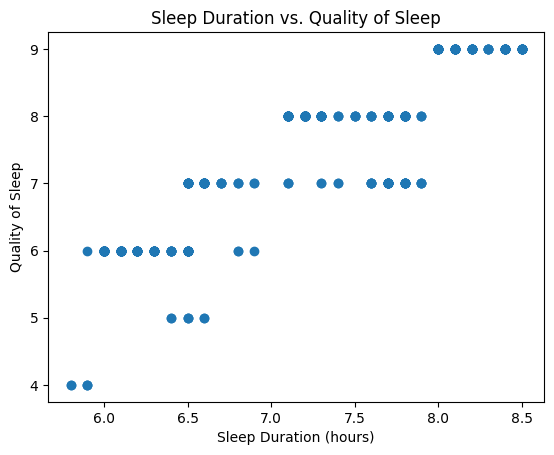

In [9]:


### Visualize Basic Statistics
df.describe().show()

### Count by disorder category
df.groupBy("Sleep Disorder").count().show()

import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
pandas_df = df.toPandas()

# Plot Sleep Duration vs Quality of Sleep
plt.scatter(pandas_df["Sleep Duration"], pandas_df["Quality of Sleep"])
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Quality of Sleep")
plt.title("Sleep Duration vs. Quality of Sleep")
plt.show()


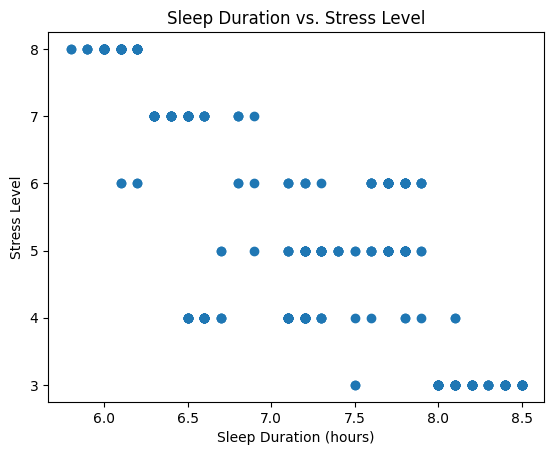

In [10]:
plt.scatter(pandas_df["Sleep Duration"], pandas_df["Stress Level"])
plt.xlabel("Sleep Duration (hours)")
plt.ylabel("Stress Level")
plt.title("Sleep Duration vs. Stress Level")
plt.show()

***Data Preprocessing***

In [11]:
from pyspark.sql.functions import col, when
# Fill missing values
sleep_df = df.na.fill({
    "Sleep Duration": df.agg({"Sleep Duration": "mean"}).collect()[0][0],
    "Quality of Sleep": 5,
    "Stress Level": 5
})

### Assigning class to each instance
# None, Insomnia, Sleep Apnea -> 0,1,2
sleep_df = sleep_df.withColumn(
    "Sleep Disorder Index",
    when(col("Sleep Disorder") == "None", 0)
    .when(col("Sleep Disorder") == "Insomnia", 1)
    .when(col("Sleep Disorder") == "Sleep Apnea", 2)
)

Our target value we are predicting is the sleep disorder, so in this step we are just assigning a lable the respective condition

In [12]:
sleep_df.show()

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+--------------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level| BMI Category|Blood Pressure|Heart Rate|Daily Steps|Sleep Disorder|Sleep Disorder Index|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+-------------+--------------+----------+-----------+--------------+--------------------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                     42|           6|   Overweight|        126/83|        77|       4200|          None|                   0|
|        2|  Male| 28|              Doctor|           6.2|               6|                     60|           8|       Normal|        125/80|        75|      10000|          None|                 

In [13]:
unique_bmi_df = sleep_df.select("BMI Category").distinct()
unique_bmi_df.show()

+-------------+
| BMI Category|
+-------------+
|Normal Weight|
|   Overweight|
|        Obese|
|       Normal|
+-------------+



In [14]:
updated_sleep_df = sleep_df.withColumn(
    "BMI Category",
    when(col("BMI Category") == "Normal Weight", "Normal")
    .otherwise(col("BMI Category"))
)

unique_bmi_df = updated_sleep_df.select("BMI Category").distinct()
unique_bmi_df.show()

+------------+
|BMI Category|
+------------+
|  Overweight|
|       Obese|
|      Normal|
+------------+



In [15]:
from pyspark.sql.functions import col, when

def ordinal_encode(bmi_category):
    return when(col(bmi_category) == "Normal", 1) \
           .when(col(bmi_category) == "Overweight", 2) \
           .when(col(bmi_category) == "Obese", 3)

# Apply the ordinal encoding to the BMI Category column
curr_df = updated_sleep_df.withColumn("Ordinal_BMI", ordinal_encode("BMI Category"))
curr_df.select("BMI Category", "Ordinal_BMI").distinct().show()


+------------+-----------+
|BMI Category|Ordinal_BMI|
+------------+-----------+
|  Overweight|          2|
|      Normal|          1|
|       Obese|          3|
+------------+-----------+



We combined normal weight and normal values and utilized ordinal encoding to convert the categorical value into a quanitative value prior to creating the predictive model

In [16]:
from pyspark.sql.functions import split
curr_df = curr_df.withColumn("Diastolic Blood Pressure", split(col("Blood Pressure"), "/").getItem(0).cast("float"))
curr_df = curr_df.withColumn("Systolic Blood Pressure", split(col("Blood Pressure"), "/").getItem(1).cast("float"))

# Drop the original 'Blood Pressure' column as it is no longer needed
curr_df = curr_df.drop("Blood Pressure")

# Display the DataFrame with the new 'Systolic' and 'Diastolic' columns
curr_df.select("Systolic Blood Pressure", "Diastolic Blood Pressure").show()

+-----------------------+------------------------+
|Systolic Blood Pressure|Diastolic Blood Pressure|
+-----------------------+------------------------+
|                   83.0|                   126.0|
|                   80.0|                   125.0|
|                   80.0|                   125.0|
|                   90.0|                   140.0|
|                   90.0|                   140.0|
|                   90.0|                   140.0|
|                   90.0|                   140.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   80.0|                   120.0|
|                   87.0|      

In [17]:
curr_df.show()

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+----------+-----------+--------------+--------------------+-----------+------------------------+-----------------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Heart Rate|Daily Steps|Sleep Disorder|Sleep Disorder Index|Ordinal_BMI|Diastolic Blood Pressure|Systolic Blood Pressure|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+----------+-----------+--------------+--------------------+-----------+------------------------+-----------------------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                     42|           6|  Overweight|        77|       4200|          None|                   0|          2|                   126.0|                   83.0|
|        2|  Mal

In [18]:

curr_df.select("Occupation").distinct().show()

+--------------------+
|          Occupation|
+--------------------+
|           Scientist|
|               Nurse|
|         Salesperson|
|              Lawyer|
|             Teacher|
|Sales Representative|
|              Doctor|
|            Engineer|
|          Accountant|
|             Manager|
|   Software Engineer|
+--------------------+



In [19]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
# Use StringIndexer to convert Occupation to numerical labels
occupation_indexer = StringIndexer(inputCol="Occupation", outputCol="OccupationIndex")
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")

indexed_df = occupation_indexer.fit(curr_df).transform(curr_df)
indexed_df = gender_indexer.fit(indexed_df).transform(indexed_df)

indexed_df.show()

+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+----------+-----------+--------------+--------------------+-----------+------------------------+-----------------------+---------------+-----------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Heart Rate|Daily Steps|Sleep Disorder|Sleep Disorder Index|Ordinal_BMI|Diastolic Blood Pressure|Systolic Blood Pressure|OccupationIndex|GenderIndex|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+----------+-----------+--------------+--------------------+-----------+------------------------+-----------------------+---------------+-----------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                     42|           6|  Overweight|        77|       4200|          None|               

In [20]:
# Create the One-Hot Encoder for OccupationIndex
occupation_encoder = OneHotEncoder(inputCol="OccupationIndex", outputCol="OccupationVec")
gender_encoder = OneHotEncoder(inputCol="GenderIndex", outputCol="GenderVec")

# Fit and transform the data
encoded_df = occupation_encoder.fit(indexed_df).transform(indexed_df)
encoded_df = gender_encoder.fit(encoded_df).transform(encoded_df)

encoded_df.show()



+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+----------+-----------+--------------+--------------------+-----------+------------------------+-----------------------+---------------+-----------+--------------+-------------+
|Person ID|Gender|Age|          Occupation|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|BMI Category|Heart Rate|Daily Steps|Sleep Disorder|Sleep Disorder Index|Ordinal_BMI|Diastolic Blood Pressure|Systolic Blood Pressure|OccupationIndex|GenderIndex| OccupationVec|    GenderVec|
+---------+------+---+--------------------+--------------+----------------+-----------------------+------------+------------+----------+-----------+--------------+--------------------+-----------+------------------------+-----------------------+---------------+-----------+--------------+-------------+
|        1|  Male| 27|   Software Engineer|           6.1|               6|                

***Feature Engineering***

In [21]:
drop_columns = ["Person ID","Gender","GenderIndex","Occupation","OccupationIndex",
                "BMI Category","Sleep Disorder",]

final_df = encoded_df.drop(*drop_columns)
final_df.show()

+---+--------------+----------------+-----------------------+------------+----------+-----------+--------------------+-----------+------------------------+-----------------------+--------------+-------------+
|Age|Sleep Duration|Quality of Sleep|Physical Activity Level|Stress Level|Heart Rate|Daily Steps|Sleep Disorder Index|Ordinal_BMI|Diastolic Blood Pressure|Systolic Blood Pressure| OccupationVec|    GenderVec|
+---+--------------+----------------+-----------------------+------------+----------+-----------+--------------------+-----------+------------------------+-----------------------+--------------+-------------+
| 27|           6.1|               6|                     42|           6|        77|       4200|                   0|          2|                   126.0|                   83.0|(10,[8],[1.0])|(1,[0],[1.0])|
| 28|           6.2|               6|                     60|           8|        75|      10000|                   0|          1|                   125.0|         

In [22]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = final_df.toPandas()

# Check for missing values in the Pandas DataFrame
na_values = pandas_df[pandas_df.isnull().any(axis=1)]
print("Rows with missing values:")
print(na_values)

# Count of missing values per column
na_count = pandas_df.isnull().sum()
print("\nCount of missing values per column:")
print(na_count)


Rows with missing values:
Empty DataFrame
Columns: [Age, Sleep Duration, Quality of Sleep, Physical Activity Level, Stress Level, Heart Rate, Daily Steps, Sleep Disorder Index, Ordinal_BMI, Diastolic Blood Pressure, Systolic Blood Pressure, OccupationVec, GenderVec]
Index: []

Count of missing values per column:
Age                         0
Sleep Duration              0
Quality of Sleep            0
Physical Activity Level     0
Stress Level                0
Heart Rate                  0
Daily Steps                 0
Sleep Disorder Index        0
Ordinal_BMI                 0
Diastolic Blood Pressure    0
Systolic Blood Pressure     0
OccupationVec               0
GenderVec                   0
dtype: int64


Model Training

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

feature_cols = [
    "Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level",
    "Stress Level", "Heart Rate", "Daily Steps",
    "Ordinal_BMI", "Diastolic Blood Pressure", "Systolic Blood Pressure",
    "OccupationVec", "GenderVec"
]
assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

assembler_df = assembler.transform(final_df)

input_data = assembler_df.select("features", "Sleep Disorder Index")


In [24]:
train_data,test_data = input_data.randomSplit([0.8,0.2],seed = 42)


In [25]:
rf = RandomForestClassifier(labelCol="Sleep Disorder Index",featuresCol="features",numTrees=100)
model = rf.fit(train_data)

In [26]:
def evaluate(model,test_data):
  predictions = model.transform(test_data)
  acc_evaluator = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index",predictionCol="prediction",metricName="accuracy")
  accuracy = acc_evaluator.evaluate(predictions)
  ##################
  f1_evaluator = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index",predictionCol="prediction",metricName="f1")
  f1_score = f1_evaluator.evaluate(predictions)
  ######################
  precision_evaluator = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index",predictionCol="prediction",metricName="weightedPrecision")
  precision = precision_evaluator.evaluate(predictions)
  ######################
  recall_evaluator = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index",predictionCol="prediction",metricName="weightedRecall")
  recall = recall_evaluator.evaluate(predictions)
  print(f"Accuracy: {accuracy}, f1:score: {f1_score}, \n weighted precision: {precision}, weighted recall: {recall}")

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, test_data):
  # Make predictions
  predictions = model.transform(test_data)
  ##print(predictions.columns)
  # Convert to Pandas DataFrame
  # Convert to Pandas DataFrame with correct columns
  preds_and_labels = predictions.select("prediction", "Sleep Disorder Index").collect()
  ###############################3
  import pandas as pd
  preds_and_labels = pd.DataFrame(preds_and_labels, columns=["prediction", "Sleep Disorder Index"])

  # Check the first few rows of the dataframe to ensure proper selection
  print(preds_and_labels.head())

  # Create confusion matrix
  cm = confusion_matrix(preds_and_labels['Sleep Disorder Index'], preds_and_labels['prediction'])

  # Plot the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()


Accuracy: 0.9090909090909091, f1:score: 0.9072727272727272, 
 weighted precision: 0.908839547549225, weighted recall: 0.9090909090909091
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


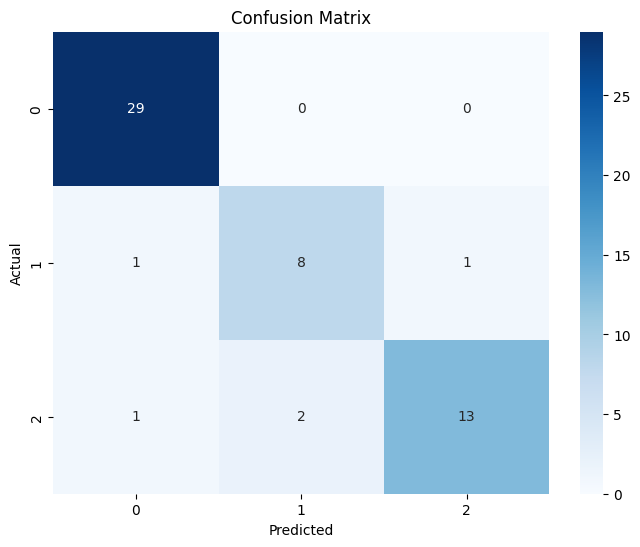

In [28]:
evaluate(model,test_data)
plot_confusion_matrix(model,test_data)

In [29]:
# Extract feature importances
def get_feature_importance(model):
  importances = model.featureImportances
  feature_importance = list(zip(feature_cols, importances))
  sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

  print("Feature Importances:")
  for feature, importance in sorted_importance:
      print(f"{feature}: {importance}")
get_feature_importance(model)

Feature Importances:
Ordinal_BMI: 0.2128627629579276
Diastolic Blood Pressure: 0.17870486662909324
Systolic Blood Pressure: 0.1295078867585288
Sleep Duration: 0.09148103706245307
OccupationVec: 0.07078049142438984
Physical Activity Level: 0.05138153414304908
Age: 0.051188034193244275
Daily Steps: 0.04199682426886833
Heart Rate: 0.040732700203137545
Stress Level: 0.03495246532657907
Quality of Sleep: 0.02697903524918878
GenderVec: 0.012600103812656572


Update: utilize different evaluation metrics, hyper parameter tuning for random forest, discuss more plots ig

We are checking perfomance without GenderVec, Quality of sleep, and stress level

Accuracy: 0.9272727272727272, f1:score: 0.9272727272727272, 
 weighted precision: 0.9272727272727272, weighted recall: 0.9272727272727272
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


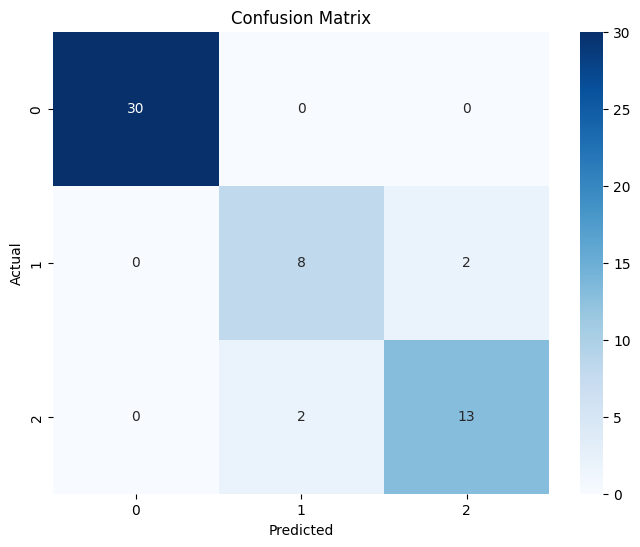

In [30]:
feature_cols = [
    "Age", "Sleep Duration", "Physical Activity Level",
    "Stress Level", "Heart Rate", "Daily Steps",
    "Ordinal_BMI", "Diastolic Blood Pressure", "Systolic Blood Pressure",
    "OccupationVec"
]
assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

assembler_df = assembler.transform(final_df)

input_data = assembler_df.select("features", "Sleep Disorder Index")

train_data,test_data = input_data.randomSplit([0.8,0.2],seed = 42)

rf_2 = RandomForestClassifier(labelCol="Sleep Disorder Index",featuresCol="features",numTrees=100)
smaller_model = rf_2.fit(train_data)
evaluate(smaller_model,test_data)
plot_confusion_matrix(smaller_model,test_data)

In [31]:
get_feature_importance(smaller_model)

Feature Importances:
Ordinal_BMI: 0.19465866393693323
Systolic Blood Pressure: 0.17457833953887086
Diastolic Blood Pressure: 0.15261023665980863
Sleep Duration: 0.10138165090498577
Age: 0.0771021573953141
OccupationVec: 0.06184484582147613
Physical Activity Level: 0.050607693576616465
Daily Steps: 0.04644788789736553
Heart Rate: 0.03817429663178811
Stress Level: 0.03113559152213907


Training with split: 0.8/0.2
Accuracy: 0.9272727272727272, f1:score: 0.9272727272727272, 
 weighted precision: 0.9272727272727272, weighted recall: 0.9272727272727272
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


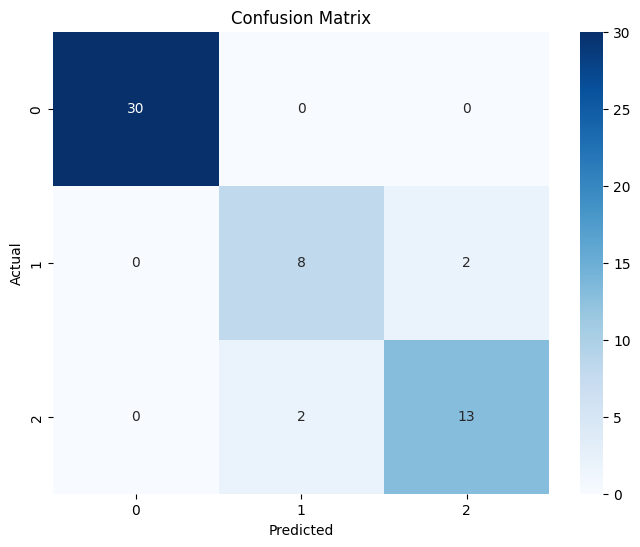

Training with split: 0.7/0.3
Accuracy: 0.9354838709677419, f1:score: 0.9363624639293258, 
 weighted precision: 0.9383512544802868, weighted recall: 0.935483870967742
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


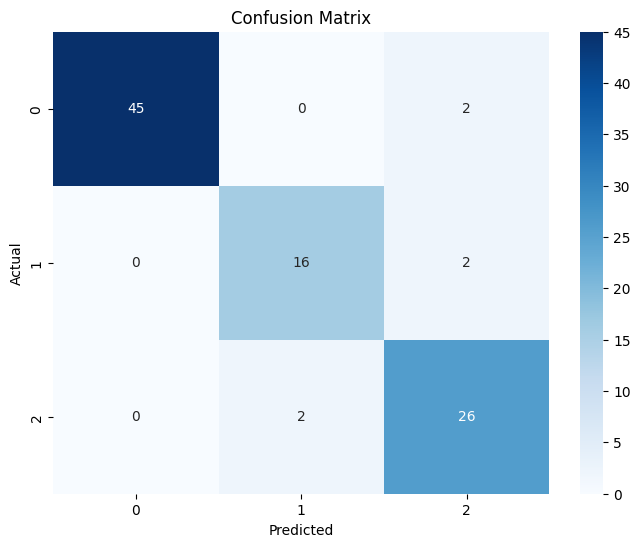

Training with split: 0.6/0.4
Accuracy: 0.9071428571428571, f1:score: 0.9084167828622132, 
 weighted precision: 0.9110528442146089, weighted recall: 0.9071428571428571
   prediction  Sleep Disorder Index
0         0.0                     0
1         1.0                     2
2         1.0                     2
3         0.0                     0
4         2.0                     2


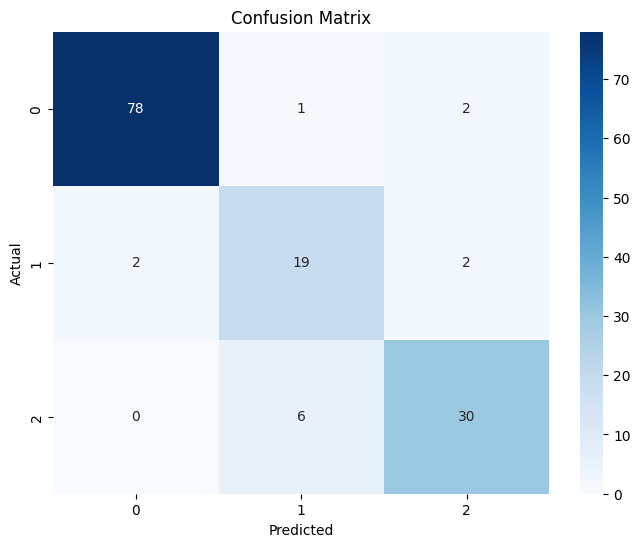

Training with split: 0.5/0.5
Accuracy: 0.9261363636363636, f1:score: 0.92687876148242, 
 weighted precision: 0.9285320104659481, weighted recall: 0.9261363636363638
   prediction  Sleep Disorder Index
0         0.0                     0
1         1.0                     1
2         1.0                     2
3         1.0                     2
4         0.0                     0


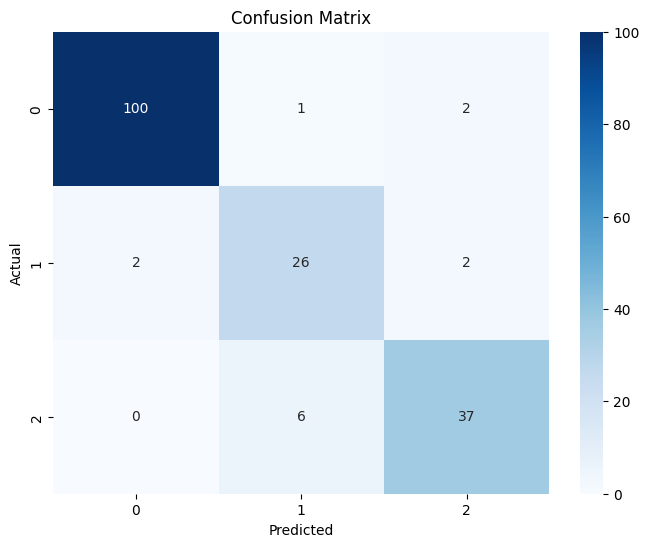

In [32]:
def evaluate_across_splits(input_data, splits=[(0.8, 0.2), (0.7, 0.3), (0.6, 0.4),(0.5,0.5)]):
    for train_size, test_size in splits:
        print(f"Training with split: {train_size}/{test_size}")

        # Split the data
        train_data, test_data = input_data.randomSplit([train_size, test_size], seed=42)

        # Train model
        rf_2 = RandomForestClassifier(labelCol="Sleep Disorder Index", featuresCol="features", numTrees=100)
        smaller_model = rf_2.fit(train_data)

        # Evaluate the model
        evaluate(smaller_model, test_data)
        plot_confusion_matrix(smaller_model, test_data)
evaluate_across_splits(input_data)

After evaluating the smaller model on different training splits I have found it works best on the 70/30 split. As the dataset becomes larger it becomes more skewed towards the majority class 0 ie No disorder

Hyper parameter tuning <br>
with 70/30 train/test split



Training with Accuracy as the evaluation metric:
Accuracy: 0.946236559139785
Best model parameters:
Num Trees: 20
Max Depth: 5
Min Instances Per Node: 1
Max Bins: 32
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


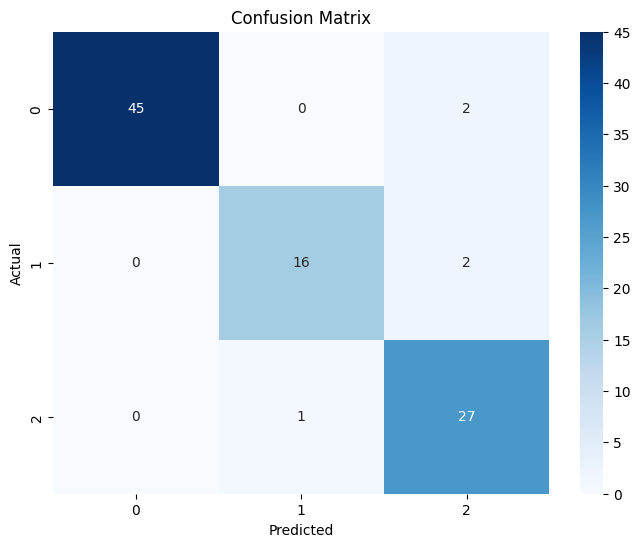


Training with Weighted Precision as the evaluation metric:
Weighted Precision: 0.9497663789761482
Best model parameters:
Num Trees: 20
Max Depth: 5
Min Instances Per Node: 1
Max Bins: 32
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


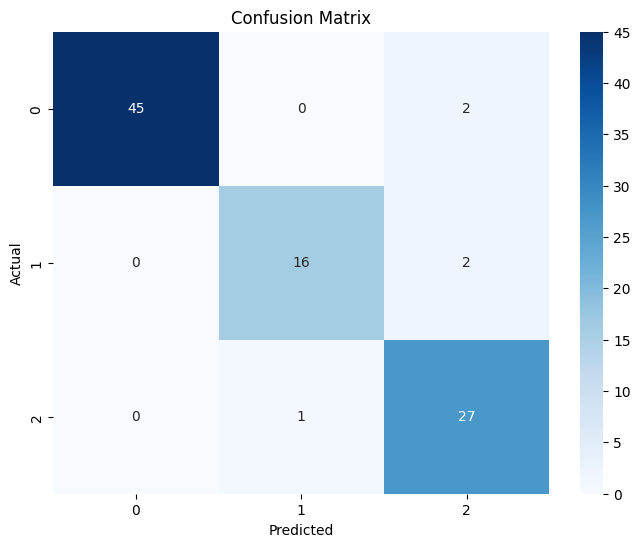


Training with Weighted Recall as the evaluation metric:
Weighted Recall: 0.946236559139785
Best model parameters:
Num Trees: 20
Max Depth: 5
Min Instances Per Node: 1
Max Bins: 32
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


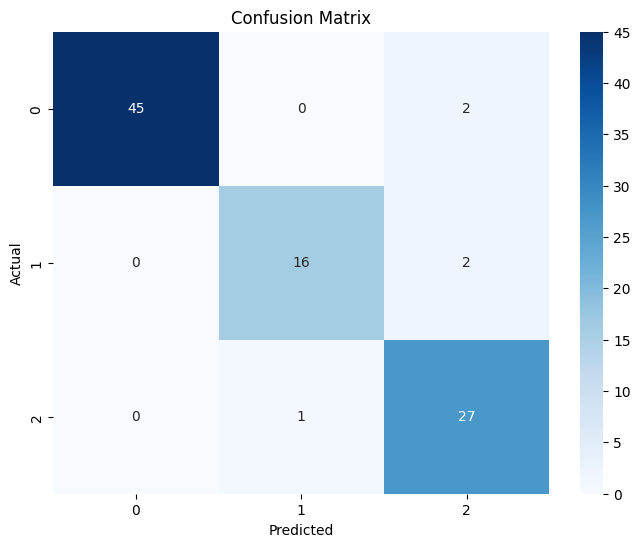


Training with F1 Score as the evaluation metric:
F1 Score: 0.9469088426965147
Best model parameters:
Num Trees: 20
Max Depth: 5
Min Instances Per Node: 1
Max Bins: 32
   prediction  Sleep Disorder Index
0         1.0                     2
1         0.0                     0
2         2.0                     2
3         2.0                     2
4         2.0                     2


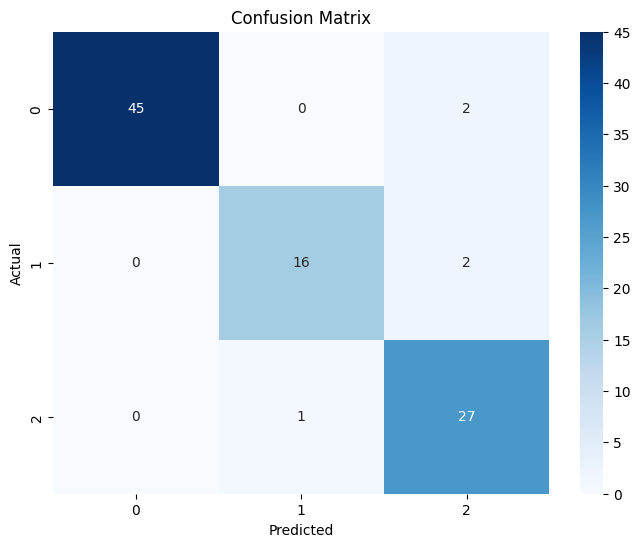

In [42]:
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
feature_cols = [
    "Age", "Sleep Duration", "Physical Activity Level",
    "Stress Level", "Heart Rate", "Daily Steps",
    "Ordinal_BMI", "Diastolic Blood Pressure", "Systolic Blood Pressure",
    "OccupationVec"
]
assembler = VectorAssembler(inputCols=feature_cols,outputCol="features")

assembler_df = assembler.transform(final_df)

input_data = assembler_df.select("features", "Sleep Disorder Index")

train_data, test_data = input_data.randomSplit([0.7, 0.3], seed=42)

rf3 = RandomForestClassifier(labelCol="Sleep Disorder Index", featuresCol="features")

##### Define the Hyperparameter Grid for Tuning
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [50, 100, 150])  # Number of trees
             .addGrid(rf.maxDepth, [5, 10, 15])    # Max depth of trees
             .addGrid(rf.minInstancesPerNode, [1, 2, 5])  # Min instances per leaf node
             .addGrid(rf.maxBins, [32, 64])        # Max number of bins
             .build())

#Define the CrossValidator
evaluator = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index", predictionCol="prediction", metricName="f1")

evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Sleep Disorder Index", predictionCol="prediction", metricName="f1")

# List of evaluators
evaluators = {
    "Accuracy": evaluator_accuracy,
    "Weighted Precision": evaluator_precision,
    "Weighted Recall": evaluator_recall,
    "F1 Score": evaluator_f1
}

# Perform cross-validation for each metric
for metric_name, evaluator in evaluators.items():
    print(f"\nTraining with {metric_name} as the evaluation metric:")

    # Train the model using cross-validation with the current evaluator
    #cv.setEvaluator(evaluator)
    tvs = TrainValidationSplit(estimator=rf3,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.7)
    tvs_model = tvs.fit(train_data)

    # Make predictions on the test data
    predictions = tvs_model.transform(test_data)

    # Evaluate the model on the current metric
    score = evaluator.evaluate(predictions)

    # Output the evaluation results for the current metric
    print(f"{metric_name}: {score}")
    best_model = tvs_model.bestModel
    print("Best model parameters:")
    print(f"Num Trees: {best_model.getNumTrees}")
    print(f"Max Depth: {best_model.getMaxDepth()}")
    print(f"Min Instances Per Node: {best_model.getMinInstancesPerNode()}")
    print(f"Max Bins: {best_model.getMaxBins()}")


    plot_confusion_matrix(best_model, test_data)

After hyper parameter tuning it appears that for each the best model has <br>
Num Trees: 20 <br>
Max Depth: 5 <br>
Min Instances per Node: 1 <br>
Max Bins: 32